[15:58:30] INFO     Generating region areas...                                                    ]8;id=312537;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py\3096904690.py]8;;\:]8;id=561097;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py#118\118]8;;\

           INFO     Region 1 completed                                                            ]8;id=441591;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py\3096904690.py]8;;\:]8;id=413770;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py#338\338]8;;\

           INFO     Region 2 completed                                                            ]8;id=656206;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py\3096904690.py]8;;\:]8;id=695400;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py#341\341]8;;\

           INFO     Region 3 completed                                                            ]8;id=488977;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py\3096904690.py]8;;\:]8;id=291052;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py#341\341]8;;\

           INFO     Region 4 completed                                                            ]8;id=491465;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py\3096904690.py]8;;\:]8;id=633415;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py#341\341]8;;\

           INFO     Region 5 completed                                                            ]8;id=62654;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py\3096904690.py]8;;\:]8;id=974269;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py#341\341]8;;\

           INFO     Region 6 completed                                                            ]8;id=752361;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py\3096904690.py]8;;\:]8;id=597872;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py#341\341]8;;\

           INFO     Region 7 completed                                                            ]8;id=770869;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py\3096904690.py]8;;\:]8;id=118831;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py#341\341]8;;\

           INFO     Region 8 completed                                                            ]8;id=708743;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py\3096904690.py]8;;\:]8;id=895734;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py#341\341]8;;\

           INFO     Region 9 completed                                                            ]8;id=889895;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py\3096904690.py]8;;\:]8;id=146401;file://C:\Users\benton.tripp\AppData\Local\Temp\ipykernel_8548\3096904690.py#341\341]8;;\

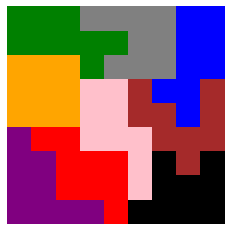

In [10]:
# Jigsaw sudoku
import time
from random import choice
from shapely.geometry import Polygon, box, Point, MultiPolygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from itertools import product
import logging, functools, operator
from rich.logging import RichHandler
       
logger_blocklist=[
        "matplotlib",
        "fontTools",
        "shapely",
        "PIL",
        "itertools"]

# Set logging format
FORMAT = "%(message)s"
logging.basicConfig(
    level=20, format=FORMAT, datefmt="[%X]", handlers=[RichHandler()]
)  # set level=20 or logging.INFO to turn off debug. to not set, level = "NOTSET"
for module in logger_blocklist:
    logging.getLogger(module).setLevel(logging.WARNING)
logger = logging.getLogger("rich")


def row_to_cell(row, r, cells, x_dir, y_dir):
    xs = (row[0], row[0] + x_dir)
    ys = (row[1], row[1] + y_dir)
    cell = box(min(xs), min(ys), max(xs), max(ys))
    if Point(row[0] + x_dir/2, row[1] + y_dir/2).within(r) and not Point(row[0] + x_dir/2, row[1] + y_dir/2).within(unary_union(cells)):
        cells.append(cell)
    return cells


def region_exterior_cells(r):
    crds = list(r.exterior.coords)
    cells = list()
    for i in range(1, len(crds)):
        row = crds[i]
        if row[0] != crds[i - 1][0]:
            # move in x direction
            x_mv = row[0] - crds[i - 1][0]
            if x_mv == 1:
                cells = row_to_cell(row, r, cells, x_dir=-1, y_dir=-1)
            else:
                cells = row_to_cell(row, r, cells, x_dir=1, y_dir=1)
        else:
            # move in y direction
            y_mv = row[1] - crds[i - 1][1]
            if y_mv == 1:
                cells = row_to_cell(row, r, cells, x_dir=1, y_dir=-1)
            else:
                cells = row_to_cell(row, r, cells, x_dir=-1, y_dir=1)
    return cells


def divide_region(r):
    ext_cells = region_exterior_cells(r)
    int_cells = r.difference(unary_union(ext_cells))
    if type(int_cells) == Polygon:
        crds = list(int_cells.exterior.coords)
        if len(crds) != 0:
            ext_cells += region_exterior_cells(int_cells)
    else:
        crds = list()
        for part in int_cells.geoms:
            ext_cells += region_exterior_cells(part)
    return ext_cells


# Adjust starting point along exterior as needed
def check_point(point, available_region, ext=True):
    cell = box(point[0], point[1], point[0]+1, point[1]+1)
    if Point(point[0]+.5, point[1]+.5).within(available_region):
        return cell
    else:
        if ext is True:
            for xy in (0, 1):
                if point[xy] == 0:
                    if Point(point[0]+.5, point[1]-.5).within(available_region) and xy == 0:
                        return box(point[0], point[1]-1, point[0]+1, point[1])
                    elif Point(point[0]-.5, point[1]+.5).within(available_region) and xy == 1:
                        return box(point[0]-1, point[1], point[0], point[1]+1)
        else:
            if Point(point[0]+.5, point[1]-.5).within(available_region):
                return box(point[0], point[1]-1, point[0]+1, point[1])
            elif Point(point[0]-.5, point[1]+.5).within(available_region):
                return box(point[0]-1, point[1], point[0], point[1]+1)
            elif Point(point[0]-.5, point[1]-.5).within(available_region):
                return box(point[0]-1, point[1]-1, point[0], point[1])
    raise ValueError



class JigsawSudoku:

    def __init__(self, size=9, auto_generate=True, timeout=10):
        self.size = size
        self.rows = list(range(1, self.size + 1))
        self.columns = list(range(1, self.size + 1))
        self.left_grid_ext = [(x, y) for x, y in zip([0]*(size + 1), range(0, size + 1))]
        self.right_grid_ext = [(x, y) for x, y in zip([size]*(size + 1), range(0, size + 1))]
        self.top_grid_ext = [(x, y) for x, y in zip(range(0, size + 1), [0]*(size + 1))]
        self.bottom_grid_ext = [(x, y) for x, y in zip(range(0, size + 1), [size]*(size + 1))]
        self.exterior = self.top_grid_ext + self.bottom_grid_ext + self.right_grid_ext + self.left_grid_ext
        self.all_cells = [Cell(box(x, y, x+1, y+1)) for (x,y) in [coord for coord in product(range(0, self.size), repeat=2)] ]
        self.corners = [
                Cell(box(0, 0, 1, 1)), # bottom left
                Cell(box(0, self.size-1, 1, self.size)), # top left
                Cell(box(self.size-1, self.size-1, self.size, self.size)), # top right
                Cell(box(self.size - 1, 0, self.size, 1)) # bottom right
                ]
        if auto_generate is True:
            generation_status = False
            self.timeout = timeout
            global PUZZLE_GEN_START_TIME
            while generation_status is False:
                logger.info('Generating region areas...')
                # Reset regions/available spaces if needed
                self.regions = dict()
                self.available_region = unary_union(self.all_cells)
                self.available_cells = self.all_cells
                # start timing
                PUZZLE_GEN_START_TIME = time.time()
                try:
                    self.generate_all_regions()
                    generation_status = True
                except (ValueError, TimeoutError, IndexError):
                    logger.info('Retrying...')
                    continue
        else:
            self.regions = dict()
            self.available_region = unary_union(self.all_cells)
            self.available_cells = self.all_cells
            

    # Automatically generate puzzles   
    def auto_generate_puzzles(self):
        self.generate_all_regions(n=self.size)

    # cells currently used to define any existing (completed) regions
    def cells_in_regions(self):
        return functools.reduce(operator.iconcat, [region.cells for region in self.regions.values()], [])

    # update any available space/cells to exclude a new cell
    def update_available(self, cell):
        self.available_cells = [c for c in self.available_cells if c.__str__() != cell.__str__()]
        self.available_region = self.available_region.difference(cell)


    # Get open spots to append new cells to a region (exclude exterior, or spaces already used - by itself or another region)
    def get_available(self, cells, exclude=[]):
        cells_str = [c.__str__() for c in cells]
        exclude_str = [c.__str__() for c in exclude]
        exclude_str = [c.__str__() for c in self.cells_in_regions() if c.__str__() not in exclude_str]
        not_used = [cell for cell in self.available_cells if cell.__str__() not in cells_str and cell.__str__() not in exclude_str]
        available = [c[1] for c in list(product(cells, not_used)) if len(
            set(c[0].boundary.coords).intersection(c[1].boundary.coords)) > 0]
        return available

    # Generate new cell from available cells
    def rand_cell(self, available):
        if len(available) == 1:
            out =  available[0]
        elif len(available) == 1:
            logger.error('Error: Available = {}'.format(available))
            raise IndexError
        else:
            out = choice(available)
        return out
    
    # start first cell at random corder
    def set_first_cell(self):
        cell = choice(self.corners)
        cells = [cell]
        # Define remaining available space/cells
        self.update_available(cell)
        return cells

    def update_cell(self, cell, cells, iter, start_len=0):
        cells.append(cell)
        iter += 1
        # Update available region & cells
        self.update_available(cell)
        if iter == self.size:
            self.regions.update({start_len + 1 : Region(cells=cells)})
            complete_status = True
        else:
            complete_status = False
        return cells, iter, complete_status
             
    # Generate the first region (out of size n)
    def gen_first_region(self):
        cells = self.set_first_cell()
        # Begin iteratively/randomly generating cells in available space
        iter = 1
        exclude = list()
        complete_status = False
        while complete_status is False:
            if time.time() - PUZZLE_GEN_START_TIME >= self.timeout:
                raise TimeoutError
            # new random (available and adjacent) cell
            available = self.get_available(cells, exclude=exclude)
            cell = self.rand_cell(available)
            # Do some checks to see if there are issues with the selected cell
            # Append to exclusions if necessary to prevent the same error from happening again
            # Confirm the cell is adjacent
            if type(unary_union(cells + [cell])) != Polygon:
                    exclude.append(cell)
            # Confirm that the cell is within the available region
            elif not cell.center.within(self.available_region):
                exclude.append(cell)
            # Confirm that if a MultiPolygon is created, its area is not less than 9
            elif type(self.available_region.difference(cell)) == MultiPolygon:
                for sub_region in self.available_region.difference(cell).geoms:
                    any_less = 0
                    if sub_region.area < self.size:
                        exclude.append(cell)
                        any_less += 1
                # only if no sub-regions are less than 9 is this ok
                if any_less == 0:
                    cells, iter, complete_status = self.update_cell(cell, cells, iter)
            else:
                cells, iter, complete_status = self.update_cell(cell, cells, iter)
                
    def gen_middle_region_start(self, exclude, start_len):
        # corners first
        if start_len in range(1,4):
            cell = choice([c for c in self.corners if c.__str__() in [ac.__str__() for ac in self.available_cells]])
            self.update_available(cell)
            cells = [cell]
        else:
            start_acquired = False
            while start_acquired is False:
                if time.time() - PUZZLE_GEN_START_TIME >= self.timeout:
                    raise TimeoutError
                available = self.get_available(cells=self.cells_in_regions())
                cell = self.rand_cell(available)
                if type(self.available_region.difference(cell)) != Polygon:
                    exclude.append(cell)
                elif cell not in self.available_cells:
                    exclude.append(cell)
                else:
                    self.update_available(cell)
                    cells = [cell]
                    start_acquired = True
        return cells, exclude
    
    def gen_next_middle_region(self, exclude, start_len):
        # Generate first cell
        cells, exlude = self.gen_middle_region_start (exclude, start_len)
        
        # Start iteration/random generation
        iter = 1
        complete_status = False
        while complete_status is False:
            if time.time() - PUZZLE_GEN_START_TIME >= self.timeout:
                raise TimeoutError
            # new random (available and adjacent) cell
            available = self.get_available(cells, exclude=exclude)
            cell = self.rand_cell(available)
            # Do some checks to see if there are issues with the selected cell
            # Append to exclusions if necessary to prevent the same error from happening again
            if type(self.available_region.difference(cell)) == MultiPolygon:
                # Rather than excluding without doing any checks, see if it is possible to "fill in the hole"
                # if possible, fill hole. Otherwise exclude
                sub_regions = self.available_region.difference(cell)
                possible_sub_region = False
                for i in range(0, len(sub_regions.geoms)):
                    r = sub_regions.geoms[i]
                    if r.area < self.size - iter:
                        #logger.info('Sub-region: {}; Area: {}; iteration: {}; cell: {};'.format(i, r.area, iter, cell.__str__()))
                        possible_sub_region = True
                        sub_r_cells = [Cell(c) for c in divide_region(r)]
                        cells += sub_r_cells
                        for c in sub_r_cells:
                            self.update_available(c)
                        iter += r.area
                        if iter == self.size:
                            self.regions.update({start_len + 1 : Region(cells=cells)})
                            complete_status = True
                        break  
                    elif r.area == self.size :
                        #logger.info('Sub-region: {}; Area: {}; iteration: {}; cell: {};'.format(i, r.area, iter, cell.__str__()))
                        possible_sub_region = True
                        sub_r_cells = [Cell(c) for c in divide_region(r)]
                        cells = sub_r_cells
                        for c in sub_r_cells:
                            self.update_available(c)
                        self.regions.update({start_len + 1 : Region(cells=cells)})
                        complete_status = True
                        break
                # if no possible sub-region, exclude
                if possible_sub_region is False:
                    exclude.append(cell)
            elif type(unary_union(cells + [cell])) == MultiPolygon:
                # Not necessarily an exclusion - it might be able to connect later
                continue
                # See if they can connect!
                #connections = [c[1] for c in list(product([cell], cells)) if len(set(c[0].boundary.coords).intersection(c[1].boundary.coords)) > 0]
                #if len(connections) > 0:
            elif cell not in self.available_cells:
                exclude.append(cell)
            else:
                cells, iter, complete_status = self.update_cell(cell, cells, iter, start_len)

    # Generate region where len(regions) > 0
    def gen_next_region(self):
        # Exclude cells in completed regions
        exclude = self.cells_in_regions()
        # Count of completed regions
        start_len = len(self.regions)
        # This means there is an isolated "available region" somewhere
        if type(self.available_region) == MultiPolygon:
            # TODO
            logger.warning('`available_region` is not a Polygon')
            pass
        else:
            # Final region - if correctly done, this should just be filled in 
            if self.available_region.area == self.size and start_len == self.size - 1:
                # Update regions dict with region #, and Region object 
                self.regions.update({start_len + 1 : Region(cells=self.available_cells)})
                self.available_region = None
                self.available_cells = None
            # This shouldn't happen
            elif self.available_region.area != self.size and start_len == self.size - 1:
                logger.error("The area of the final region != {}".format(self.size))
                raise ValueError
            # Not the first or final region being filled - primary case
            else:
                self.gen_next_middle_region(exclude, start_len)
    
    # Generate all regions (main function)
    def generate_all_regions(self, n=None):
        if n is None:
            n = self.size
        self.gen_first_region()
        logger.info('Region {} completed'.format(len(self.regions)))
        while len(self.regions) < n:
            self.gen_next_region()
            logger.info('Region {} completed'.format(len(self.regions)))



class Region(JigsawSudoku):

    def __init__(self, cells):
        self.cells = cells
        self.shape = unary_union(self.cells)
        self.region_exterior = [coord for coord in self.shape.exterior.coords]

class Cell(JigsawSudoku):
    def __init__(self, shapely_box):
        if not isinstance(shapely_box, Polygon):
            raise TypeError("Cell must be a shapely box (Polygon) of 1x1 dimensions")
        if shapely_box.area != 1:
            raise TypeError("Cell must be a shapely box (Polygon) of 1x1 dimensions")
        if len(shapely_box.exterior.coords) != 5:
            raise TypeError("Cell must be a shapely box (Polygon) of 1x1 dimensions")
        self.cell = shapely_box
        self.value = None
        self.coords = list(shapely_box.exterior.coords)[:-1]
        self.area = shapely_box.area
        self.origin = self.coords[3]
        self.x_start = self.origin[0]
        self.y_start = self.origin[1]
        self.row = self.x_start + 1
        self.column = self.y_start + 1
        self.index = (self.row, self.column) #(x,y)
        self._geom = shapely_box._geom
        self.boundary = shapely_box.boundary
        self.center_coords = (self.x_start + .5, self.y_start + .5)
        self.center = Point(self.center_coords[0], self.center_coords[1])

    def __str__(self):
        return 'box({}, {}, {}, {})'.format(self.x_start, self.y_start, self.x_start + 1, self.y_start + 1)


def main(n=9, plot=False, save=False, timeout=6):
    js = JigsawSudoku(size=n, timeout=6)
    #js.generate_all_regions(n=n)
    if plot is True:
        # Plotting
        fig, ax = plt.subplots()
        ax.set_axis_off()
        ax.margins(x=0, y=0, tight=True)
        ax.set_aspect('equal')
        colors = {
                1: 'black',
                2: 'green',
                3: 'purple',
                4: 'blue',
                5: 'red',
                6: 'orange',
                7: 'pink',
                8: 'brown',
                9: 'gray'
            }
        for i in range(1, n+1):
            points = js.regions[i].region_exterior
            xs = [point[0] for point in points]
            ys = [point[1] for point in points]
            ax.fill(xs, ys, fc=colors[i], ec='none')
        if save is True:
            plt.savefig('../docs/grid.svg', format='svg')
    return js


if __name__ == '__main__':
    js = main(9, True, False, 6)